# Project 4 - Books Recommendation using SVD
Collaborative based filtering->Item based

In [1]:
# !pip install scikit-surprise

# Import Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from surprise import accuracy, Dataset, Reader, SVD, BaselineOnly, PredictionImpossible
from surprise.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
import random
import numpy as np
import statistics as st

# Explore the data

In [2]:
#Creating dataframes from csv files to read the data
books_df_original = pd.read_csv('./Resources/BooksO.csv')
users_df = pd.read_csv('./Resources/UsersO.csv')
ratings_df_original = pd.read_csv('./Resources/RatingsO.csv')

/var/folders/3g/t4y_09d901v7s2qw9dqk8jzw0000gn/T/ipykernel_14716/2406171956.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df_original = pd.read_csv('./Resources/BooksO.csv')
/var/folders/3g/t4y_09d901v7s2qw9dqk8jzw0000gn/T/ipykernel_14716/2406171956.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  users_df = pd.read_csv('./Resources/UsersO.csv')
/var/folders/3g/t4y_09d901v7s2qw9dqk8jzw0000gn/T/ipykernel_14716/2406171956.py:4: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_df_original = pd.read_csv('./Resources/RatingsO.csv')


In [3]:
# Filter out data with no publication year
books_df = books_df_original[books_df_original['Year-Of-Publication'] != 0]

In [4]:
# remove duplicated books records if any by looking at ISBN
books_df=books_df.drop_duplicates(subset=['ISBN'])

In [5]:
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267790 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 267790 non-null  object
 1   Book-Title           267790 non-null  object
 2   Book-Author          267788 non-null  object
 3   Year-Of-Publication  267790 non-null  object
 4   Publisher            267788 non-null  object
 5   Image-URL-S          267790 non-null  object
 6   Image-URL-M          267790 non-null  object
 7   Image-URL-L          267787 non-null  object
dtypes: object(8)
memory usage: 18.4+ MB


In [11]:
duplicated_titles=books_df[books_df.duplicated(subset=['Book-Title'],keep=False)].sort_values(by='Book-Title')
duplicated_titles.head()
# ????????how to handle those duplicates????????

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
75637,1565920465,!%@ (A Nutshell handbook),Donnalyn Frey,1994,O'Reilly,http://images.amazon.com/images/P/1565920465.0...,http://images.amazon.com/images/P/1565920465.0...,http://images.amazon.com/images/P/1565920465.0...
156341,1565920317,!%@ (A Nutshell handbook),Donnalyn Frey,1993,O'Reilly,http://images.amazon.com/images/P/1565920317.0...,http://images.amazon.com/images/P/1565920317.0...,http://images.amazon.com/images/P/1565920317.0...
140618,0792276833,'A Hell of a Place to Lose a Cow': An American...,Tim Brookes,2000,National Geographic,http://images.amazon.com/images/P/0792276833.0...,http://images.amazon.com/images/P/0792276833.0...,http://images.amazon.com/images/P/0792276833.0...
158204,0792277295,'A Hell of a Place to Lose a Cow': An American...,Tim Brookes,2001,National Geographic,http://images.amazon.com/images/P/0792277295.0...,http://images.amazon.com/images/P/0792277295.0...,http://images.amazon.com/images/P/0792277295.0...
10438,0451168089,'Salem's Lot,Stephen King,1990,Signet Book,http://images.amazon.com/images/P/0451168089.0...,http://images.amazon.com/images/P/0451168089.0...,http://images.amazon.com/images/P/0451168089.0...


In [8]:
# create a dictionary for mapping between Book-Title ans ISBN
isbn_title_dict=dict(books_df.set_index('ISBN')['Book-Title'])


In [9]:
ratings_df=ratings_df_original.copy()
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433684 entries, 0 to 433683
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      433684 non-null  object
 1   ISBN         433682 non-null  object
 2   Book-Rating  433682 non-null  object
dtypes: object(3)
memory usage: 9.9+ MB


In [10]:
# update the datatype of a 'Book-Rating' field to numeric one
ratings_df['Book-Rating']=pd.to_numeric(ratings_df['Book-Rating'],errors='coerce')
# and check the result
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433684 entries, 0 to 433683
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   User-ID      433684 non-null  object 
 1   ISBN         433682 non-null  object 
 2   Book-Rating  433681 non-null  float64
dtypes: float64(1), object(2)
memory usage: 9.9+ MB


In [11]:
############## users with solid number of reviews shortens a lot!
# find the list of ISBN that we have book info for them
isbn=books_df['ISBN'].unique()

# adjust ratings  dataframe to match with those books
ratings_df=ratings_df[ratings_df['ISBN'].isin(isbn)]
############## users with solid number of reviews shortens a lot!

In [12]:
#check for n/a values
ratings_df[ratings_df['Book-Rating'].isna()|ratings_df['ISBN'].isna()|ratings_df['User-ID'].isna()]

,User-ID,ISBN,Book-Rating


In [13]:
# drop rows with N/As if any
ratings_df=ratings_df[~(ratings_df['Book-Rating'].isna()|ratings_df['ISBN'].isna()|ratings_df['User-ID'].isna())]
ratings_df

,User-ID,ISBN,Book-Rating
1,276729,052165615X,3.0
5,276744,038550120X,7.0
11,276747,1885408226,7.0
13,276751,3596218098,8.0
18,276762,3453092007,8.0
...,...,...,...
433639,276688,038073107X,6.0
433642,276688,044661193X,7.0
433661,276688,1551669315,6.0
433662,276688,1575660792,7.0


In [14]:
# Check distribution by scores 
groupped_r_scores=ratings_df.groupby(['Book-Rating']).size()
groupped_r_scores

Book-Rating
1.0       380
2.0       581
3.0      1216
4.0      1770
5.0      8884
6.0      6766
7.0     13770
8.0     18513
9.0     11850
10.0    14788
dtype: int64

<Axes: xlabel='Book-Rating'>

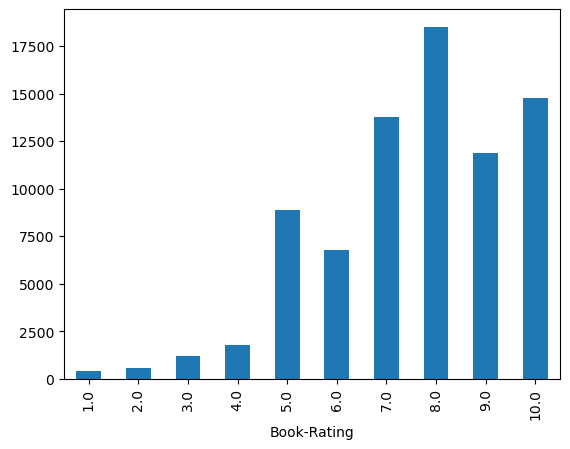

In [15]:
groupped_r_scores.plot.bar()

In [16]:
# check distribution by number of rated books per user
groupped_r_users=ratings_df.groupby('User-ID')['Book-Rating'].count()
groupped_r_users=pd.DataFrame(groupped_r_users).reset_index()
groupped_r_users

,User-ID,Book-Rating
0,8,5
1,12,1
2,22,1
3,64,1
4,69,1
...,...,...
26234,276670,8
26235,276680,11
26236,276681,2
26237,276688,5


In [17]:
users_count_r=groupped_r_users['Book-Rating'].value_counts()
users_count_r=pd.DataFrame(users_count_r).reset_index()
users_count_r.columns = ['Book-Ratings count', 'users count']
users_count_r.sort_values(by='Book-Ratings count')

,Book-Ratings count,users count
0,1,16938
1,2,3587
2,3,1618
3,4,990
4,5,590
...,...,...
89,240,1
70,289,1
79,343,1
104,1047,1


In [18]:
# split df[col_name] into bins
### TO REDO bining part, using approach learned during classes!!!!!!!!!!!!!!!!!
def binning(bins_start, df, col_name, bin_col_name):  
    # bins_start is a list with start points of ranges for binning, e.g. bins_start=[0,25,50,100,300]
    # df - dataframe with data to bin
    # col_name - name of a column in df to bin
    # name of newly created column for labels with bin identificator
    bins_labels=[]
    for i in range(0,len(bins_start)):
        if i<(len(bins_start)-1):
            label=f'({bins_start[i]}-{bins_start[i+1]}]'
        else:
            label=f'>{bins_start[i]}'
        bins_labels.append(label)
    df[bin_col_name]=''
    for index,row in df.iterrows():
        for i in range(0,len(bins_start)):
            if i<(len(bins_start)-1):
                if ((row[col_name]>bins_start[i]) and (row[col_name]<=bins_start[i+1])):
                    df.loc[index,bin_col_name]=bins_labels[i]
            else:
                if row[col_name]>bins_start[i]:
                    df.loc[index,bin_col_name]=bins_labels[i]
    # df[df[bin_col_name]=='']
    return df

In [19]:
# split book-ratings count per user into bins to visualize and undertand the distribution
users_count_r=binning([0,25,50,100,300], users_count_r, 'Book-Ratings count', 'Rated Books in Range')
users_count_r

,Book-Ratings count,users count,Rated Books in Range
0,1,16938,(0-25]
1,2,3587,(0-25]
2,3,1618,(0-25]
3,4,990,(0-25]
4,5,590,(0-25]
...,...,...,...
101,143,1,(100-300]
102,78,1,(50-100]
103,122,1,(100-300]
104,1047,1,>300


In [20]:
users_count_binned=users_count_r.groupby('Rated Books in Range')['users count'].sum().sort_values(ascending=False)
users_count_binned

Rated Books in Range
(0-25]       25908
(25-50]        241
(50-100]        64
(100-300]       23
>300             3
Name: users count, dtype: int64

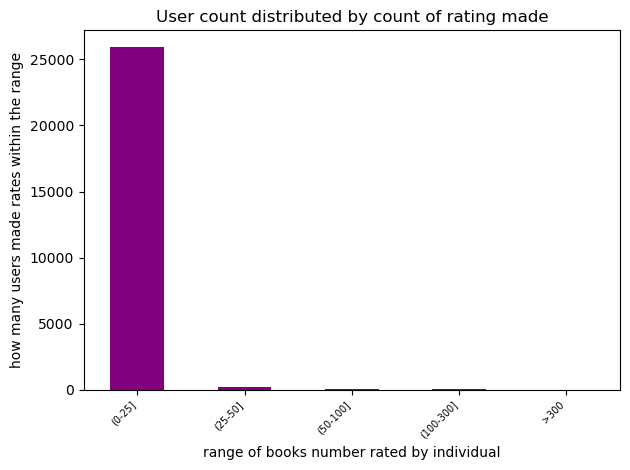

In [21]:
ax=users_count_binned.plot.bar(color='purple')
ax.set_title("User count distributed by count of rating made")
ax.set_xlabel("range of books number rated by individual")
ax.set_ylabel("how many users made rates within the range")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=7)
plt.tight_layout()

In [22]:
# check distribution by number of users, who gave rates for a book
groupped_r_books=ratings_df.groupby('ISBN')['User-ID'].count().sort_values()
groupped_r_books=pd.DataFrame(groupped_r_books).reset_index().rename(columns={'User-ID':'count_of_users_rated'})
groupped_r_books

,ISBN,count_of_users_rated
0,000104687X,1
1,1894593073,1
2,1894549090,1
3,1894498178,1
4,1894463196,1
...,...,...
40292,043935806X,206
40293,044021145X,208
40294,067976402X,256
40295,044023722X,281


In [23]:
# split book-ratings count per book into bins to visualize and undertand the distribution
groupped_r_books=binning([0,25,50,100,300], groupped_r_books, 'count_of_users_rated', 'users_count_range')
groupped_r_books

,ISBN,count_of_users_rated,users_count_range
0,000104687X,1,(0-25]
1,1894593073,1,(0-25]
2,1894549090,1,(0-25]
3,1894498178,1,(0-25]
4,1894463196,1,(0-25]
...,...,...,...
40292,043935806X,206,(100-300]
40293,044021145X,208,(100-300]
40294,067976402X,256,(100-300]
40295,044023722X,281,(100-300]


In [24]:
books_count_binned=groupped_r_books.groupby('users_count_range')['ISBN'].count().sort_values(ascending=False)
books_count_binned

users_count_range
(0-25]       40137
(25-50]         94
(50-100]        53
(100-300]       12
>300             1
Name: ISBN, dtype: int64

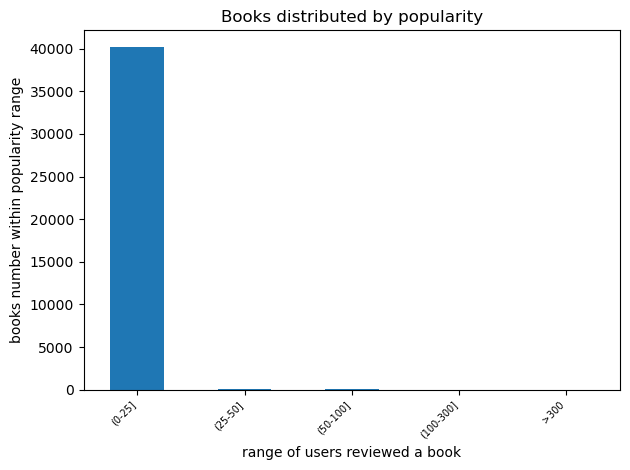

In [25]:
ax=books_count_binned.plot.bar()
ax.set_title('Books distributed by popularity')
ax.set_xlabel("range of users reviewed a book")
ax.set_ylabel("books number within popularity range")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=7)
plt.tight_layout()

In [26]:
# to find the most liked books (positively popular) we can consider approach like this one
ratings_df[ratings_df['Book-Rating']>=8].groupby('ISBN').count().sort_values('Book-Rating',ascending=False)[:10]

,User-ID,Book-Rating
ISBN,,
059035342X,276,276
043935806X,176,176
067976402X,173,173
044023722X,155,155
044021145X,135,135
1400034779,126,126
1558743669,91,91
068484477X,91,91
044651652X,89,89


# Train the model

# Training: data preparation

### Change ISBN with Titles
Merge ratings with books data in order to change isbn with title and leave only those ratings data for which we have title info


In [27]:
ratings_df

,User-ID,ISBN,Book-Rating
1,276729,052165615X,3.0
5,276744,038550120X,7.0
11,276747,1885408226,7.0
13,276751,3596218098,8.0
18,276762,3453092007,8.0
...,...,...,...
433639,276688,038073107X,6.0
433642,276688,044661193X,7.0
433661,276688,1551669315,6.0
433662,276688,1575660792,7.0


In [28]:
ratings_df=pd.merge(books_df,ratings_df,on='ISBN', how = 'inner')
ratings_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,8,5.0
1,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,http://images.amazon.com/images/P/1552041778.0...,http://images.amazon.com/images/P/1552041778.0...,http://images.amazon.com/images/P/1552041778.0...,8,5.0
2,1558746218,A Second Chicken Soup for the Woman's Soul (Ch...,Jack Canfield,1998,Health Communications,http://images.amazon.com/images/P/1558746218.0...,http://images.amazon.com/images/P/1558746218.0...,http://images.amazon.com/images/P/1558746218.0...,61501,7.0
3,1558746218,A Second Chicken Soup for the Woman's Soul (Ch...,Jack Canfield,1998,Health Communications,http://images.amazon.com/images/P/1558746218.0...,http://images.amazon.com/images/P/1558746218.0...,http://images.amazon.com/images/P/1558746218.0...,148514,10.0
4,1558746218,A Second Chicken Soup for the Woman's Soul (Ch...,Jack Canfield,1998,Health Communications,http://images.amazon.com/images/P/1558746218.0...,http://images.amazon.com/images/P/1558746218.0...,http://images.amazon.com/images/P/1558746218.0...,263256,10.0
...,...,...,...,...,...,...,...,...,...,...
78513,3453065123,Ich war Hitlerjunge Salomon. ( erlebt und erfa...,Sally Perel,1993,Heyne,http://images.amazon.com/images/P/3453065123.0...,http://images.amazon.com/images/P/3453065123.0...,http://images.amazon.com/images/P/3453065123.0...,274220,9.0
78514,3525335423,Das Deutsche Kaiserreich 1871-1918.,Hans-Ulrich Wehler,1994,Vandenhoeck &amp; Ruprecht,http://images.amazon.com/images/P/3525335423.0...,http://images.amazon.com/images/P/3525335423.0...,http://images.amazon.com/images/P/3525335423.0...,274220,8.0
78515,3548740146,Wicca. Eine EinfÃ?Â¼hrung in weiÃ?Â?e Magie.,Scott Cunningham,2001,"Ullstein TB-Vlg., B.",http://images.amazon.com/images/P/3548740146.0...,http://images.amazon.com/images/P/3548740146.0...,http://images.amazon.com/images/P/3548740146.0...,274220,6.0
78516,381440176X,"Ein Fall fÃ?Â¼r TKKG, Bd.50, Sklaven fÃ?Â¼r Wu...",Stefan Wolf,1989,Pelikan,http://images.amazon.com/images/P/381440176X.0...,http://images.amazon.com/images/P/381440176X.0...,http://images.amazon.com/images/P/381440176X.0...,274220,8.0


In [29]:
ratings_df=ratings_df.drop(['ISBN','Book-Author','Year-Of-Publication','Publisher','Image-URL-S','Image-URL-M','Image-URL-L'], axis=1)
ratings_df

,Book-Title,User-ID,Book-Rating
0,Where You'll Find Me: And Other Stories,8,5.0
1,Jane Doe,8,5.0
2,A Second Chicken Soup for the Woman's Soul (Ch...,61501,7.0
3,A Second Chicken Soup for the Woman's Soul (Ch...,148514,10.0
4,A Second Chicken Soup for the Woman's Soul (Ch...,263256,10.0
...,...,...,...
78513,Ich war Hitlerjunge Salomon. ( erlebt und erfa...,274220,9.0
78514,Das Deutsche Kaiserreich 1871-1918.,274220,8.0
78515,Wicca. Eine EinfÃ?Â¼hrung in weiÃ?Â?e Magie.,274220,6.0
78516,"Ein Fall fÃ?Â¼r TKKG, Bd.50, Sklaven fÃ?Â¼r Wu...",274220,8.0


In [30]:
ratings_df=ratings_df.dropna()
ratings_df

,Book-Title,User-ID,Book-Rating
0,Where You'll Find Me: And Other Stories,8,5.0
1,Jane Doe,8,5.0
2,A Second Chicken Soup for the Woman's Soul (Ch...,61501,7.0
3,A Second Chicken Soup for the Woman's Soul (Ch...,148514,10.0
4,A Second Chicken Soup for the Woman's Soul (Ch...,263256,10.0
...,...,...,...
78513,Ich war Hitlerjunge Salomon. ( erlebt und erfa...,274220,9.0
78514,Das Deutsche Kaiserreich 1871-1918.,274220,8.0
78515,Wicca. Eine EinfÃ?Â¼hrung in weiÃ?Â?e Magie.,274220,6.0
78516,"Ein Fall fÃ?Â¼r TKKG, Bd.50, Sklaven fÃ?Â¼r Wu...",274220,8.0


In [31]:
# check if there are duplicated records when same user rated book(s) with same title several times
ratings_df[ratings_df.duplicated(subset=['Book-Title', 'User-ID'],keep=False)].sort_values(by=['Book-Title','User-ID'])

,Book-Title,User-ID,Book-Rating
29815,A Language Older Than Words,11676,10.0
44715,A Language Older Than Words,11676,8.0
29816,A Language Older Than Words,72428,10.0
44717,A Language Older Than Words,72428,10.0
649,A Painted House,11676,8.0
...,...,...,...
53617,Widowhood Happens,87582,10.0
53645,Zoids Chaotic Century (Zoids: Chaotic Century ...,63714,10.0
53646,Zoids Chaotic Century (Zoids: Chaotic Century ...,63714,10.0
53647,Zoids Chaotic Century (Zoids: Chaotic Century ...,63714,10.0


In [32]:
# drop duplicated records when same user could rate book(s) with same title
ratings_df=ratings_df.drop_duplicates()
ratings_df

,Book-Title,User-ID,Book-Rating
0,Where You'll Find Me: And Other Stories,8,5.0
1,Jane Doe,8,5.0
2,A Second Chicken Soup for the Woman's Soul (Ch...,61501,7.0
3,A Second Chicken Soup for the Woman's Soul (Ch...,148514,10.0
4,A Second Chicken Soup for the Woman's Soul (Ch...,263256,10.0
...,...,...,...
78513,Ich war Hitlerjunge Salomon. ( erlebt und erfa...,274220,9.0
78514,Das Deutsche Kaiserreich 1871-1918.,274220,8.0
78515,Wicca. Eine EinfÃ?Â¼hrung in weiÃ?Â?e Magie.,274220,6.0
78516,"Ein Fall fÃ?Â¼r TKKG, Bd.50, Sklaven fÃ?Â¼r Wu...",274220,8.0


In [33]:
#??????????
# should we may have avg rate here per duplicates set????
#??????????

### Only leave statistically signifacant data

In [34]:
# Define whar are the number of rates per book and books rated by user we treat as statistically significant
min_books_rated_by_user=50
min_rates_received_by_book=25

In [35]:
groupped_r_users=ratings_df.groupby('User-ID')['Book-Rating'].count()
groupped_r_users[:5]

User-ID
8     5
12    1
22    1
64    1
69    1
Name: Book-Rating, dtype: int64

In [36]:
groupped_r_books=ratings_df.groupby('Book-Title')['User-ID'].count()
groupped_r_books[:5]

Book-Title
 Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth    7
 Final Fantasy Anthology: Official Strategy Guide (Brady Games)                                     2
 Flight of Fancy: American Heiresses (Zebra Ballad Romance)                                         1
 Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)                                   1
 Q-Zone (Star Trek The Next Generation, Book 48)                                                    2
Name: User-ID, dtype: int64

In [37]:
# #select only those books which were rated more than min_rates_received_by_book
# titles_with_acceptable_rates_count=list(groupped_r_books[groupped_r_books>min_rates_received_by_book].index)
# titles_with_acceptable_rates_count[:5]

In [38]:
# #select only those users (user_id) who rated more than min_books_rated_by_user books
# user_ids_with_acceptable_books_count_rated=list(groupped_r_users[groupped_r_users>min_books_rated_by_user].index)
# user_ids_with_acceptable_books_count_rated[:5]

In [39]:
# # filter rating-user data to have only books/users of interest (which have highest rates count and rated highest number of books respectively)
# rating_input_df=ratings_df[ratings_df['Book-Title'].isin(titles_with_acceptable_rates_count)&ratings_df['User-ID'].isin(user_ids_with_acceptable_books_count_rated)]
# rating_input_df

In [40]:
rating_input_df=ratings_df

### Prepare data for parsing by 'surprise algorithms' 

In [41]:
# Even having dataframe we need to create a 'reader' with the 'rating_scale' parameter to let know that our dataset has ratings from 1 to 10
# https://surprise.readthedocs.io/en/stable/getting_started.html#load-custom
reader = Reader(rating_scale=(1,10))

# and create respective surprise.dataset object, so that our data are in a proper format for the recommendation algorithms
data_surprise_o = Dataset.load_from_df(rating_input_df[['User-ID','Book-Title','Book-Rating']], reader)

data_surprise_o

#### Split our data into train and test in ratio 8:2
Use random_state = 42 so that we receive reproducable output

In [42]:
random_state = 42

In [43]:
# Option1:
# Reference: https://surprise.readthedocs.io/en/stable/getting_started.html?highlight=train_test_split#train-test-split-and-the-fit-method

train_set, test_set = train_test_split(data_surprise_o, test_size=0.2, shuffle=True, random_state=random_state)

train_data = list(train_set.all_ratings())

print(f'Size of train_set: {len(train_data)}')
print(f'Number of users in train_set: {train_set.n_users}')
print(f'Number of books in train_set: {train_set.n_items}')

train_set

Size of train_set: 62760
Number of users in train_set: 22733
Number of books in train_set: 33216


In [44]:
train_set.all_items()

range(0, 33216)

In [45]:
# Option2:
# reference: https://datascience.stackexchange.com/questions/73583/how-to-train-test-split-and-cross-validate-in-surprise
# get already parsed data in its raw form
# check here for raw vs inner https://surprise.readthedocs.io/en/stable/FAQ.html#what-are-raw-and-inner-ids
train_dataset_obj = Dataset.load_from_df(rating_input_df[['User-ID','Book-Title','Book-Rating']], reader) # we kind of copying the original dataset
raw_data = train_dataset_obj.raw_ratings

# shuffle ratings to ensure that the data is randomized
np.random.seed(random_state)
np.random.shuffle(raw_data)
display (f'Size of raw_data: {len(raw_data)}')
display(f'Few elements of raw_data: {raw_data[:5]}')

#???????????????
# WHY DO WE HAVE 'None' here as 4-th element?
#???????????????


'Size of raw_data: 78450'

'Few elements of raw_data: [(80626, \'HeiÃ?Â?t du wirklich Hassan Schmidt? Ein Krimi. ( Ab 13 J.).\', 6.0, None), (123597, \'My Lesbian Husband : Landscapes of a Marriage\', 8.0, None), (\'206563\', \'Gap Creek: The Story of a Marriage\', 10.0, None), (505, \'The Night Listener\', 9.0, None), (60244, "Angela\'s Ashes: A Memoir", 9.0, None)]'

In [46]:
# find the lenght of train set having it should be 80% of all data
train_lenght = int(0.8 * len(raw_data))
# split the whole set of raw data into train and test one
train_part_raw = raw_data[:train_lenght]
test_part_raw = raw_data[train_lenght:]

# create respective train object and test set
train_dataset_obj.raw_ratings=train_part_raw  #trick to receive a dataset object from raw data 'train_part_raw'
train_set = train_dataset_obj.build_full_trainset()
test_set = train_dataset_obj.construct_testset(test_part_raw)
print(f'Type of train_set: {type(train_set)}')
print(f'Type of test_set: {type(test_set)}')

Type of train_set: <class 'surprise.trainset.Trainset'>
Type of test_set: <class 'list'>


In [47]:
# check train and test data
train_data = list(train_set.all_ratings())

display('------Train Set------')
print(f'Size of train_set: {len(train_data)}')
print(f'Number of users in train_set: {train_set.n_users}')
print(f'Number of books in train_set: {train_set.n_items}')
display(f'Few elements of train_set (user, book, rating): {train_data[:15]}')
display('------Test Set------')
print(f'Size of test_set: {len(test_set)}')
display(f'Few elements of test_set (user, book, rating): {test_set[:15]}')

'------Train Set------'

Size of train_set: 62760
Number of users in train_set: 22733
Number of books in train_set: 33216


'Few elements of train_set (user, book, rating): [(0, 0, 6.0), (1, 1, 8.0), (1, 1881, 8.0), (1, 9064, 9.0), (1, 15018, 10.0), (1, 15511, 8.0), (1, 16350, 8.0), (1, 19856, 8.0), (1, 20426, 8.0), (1, 10159, 8.0), (1, 27876, 10.0), (1, 35, 8.0), (1, 29836, 8.0), (2, 2, 10.0), (2, 4230, 10.0)]'

'------Test Set------'

Size of test_set: 15690


"Few elements of test_set (user, book, rating): [('177166', 'The Life You Were Born to Live: A Guide to Finding Your Life Purpose', 10.0), (134529, 'Harry Potter and the Order of the Phoenix (Book 5)', 10.0), (20961, 'Tarot: A New Handbook for the Apprentice (Connolly Tarot)', 9.0), ('234828', 'The Power of One', 7.0), ('203074', 'Spain : A Picture Book To Remember Her By', 10.0), (3416, 'Zauber gegen die KÃ?Â¤lte. Erotische Gedichte. Spanisch - Deutsch.', 8.0), (125039, 'IF THERE BE THORNS (Dollanger Saga (Paperback))', 7.0), ('183061', 'Diction for Singers: A Concise Reference for English, Italian, Latin, German, French and Spanish Pronunciation', 6.0), (3373, 'Dead Eyes', 7.0), ('217740', 'Sultana (Spanish Edition)', 5.0), (47316, 'The Boyfriend Wars (The Boyfriend Club Special Edition, No 2)', 6.0), (122045, 'Zijn bliksem, zijn donder: Over de Mattheus-Passie van Johann Sebastian Bach', 9.0), ('264509', 'La Courte Paille', 5.0), (11198, 'Der wilde Tanz der SeidenrÃ?Â¶cke.', 9.0), (

In [48]:
# not really sure I understand the difference here between options (in general it's stated that the second one works if we want to cross validate)
# can we receive more input here?????

## Training: cross validate the model
Make preliminary estimation of error in predictions using RMSE metric for SVD() model and the whole set of data split into 5 folds


In [49]:
# reference: https://surprise.readthedocs.io/en/stable/getting_started.html?highlight=cross_validate#use-cross-validation-iterators

# define number of subsets the dataset will be partitioned for cross validations
folds_n=5

# define a cross-validation iterator
kf = KFold(n_splits=folds_n)

algo = [BaselineOnly(),SVD()]

for i in algo:
    mean_rmse=[]
    for trainset, testset in kf.split(data_surprise_o):

        # train and test algorithm.
        i.fit(trainset)
        predictions = i.test(testset)

        # Compute and print Root Mean Squared Error
        mean_rmse.append(accuracy.rmse(predictions))

    # Find an average rmse for all the folds
    mean_rmse=st.mean(mean_rmse)
    display(f'Average Root Mean Square Error (RMSE) for {i.__class__.__name__} is {round(mean_rmse,2)}')

Estimating biases using als...
RMSE: 1.7640
Estimating biases using als...
RMSE: 1.7355
Estimating biases using als...
RMSE: 1.7373
Estimating biases using als...
RMSE: 1.7273
Estimating biases using als...
RMSE: 1.7306


'Average Root Mean Square Error (RMSE) for BaselineOnly is 1.74'

RMSE: 1.7276
RMSE: 1.7081
RMSE: 1.7334
RMSE: 1.7361
RMSE: 1.7278


'Average Root Mean Square Error (RMSE) for SVD is 1.73'

## Training: identify best parameters

In [50]:
# # reference: https://medium.com/p/61c269402919
# # within the dictionary param_grid set ranges for parameters to try out, where 
# #  - key: parameter name, 
# #  - value:  list of parameter values to try
# param_grid = {'n_factors':[10,20,50,100,150], 'n_epochs':[10,20,30,50, 100], 'lr_all':[0.002,0.005,0.01,0.3],'reg_all':[0.02, 0.1, 0.2]}
# # n_factors - number of latent factors (Default is 100)
# # n_epochs - number of iterations (Default is 20)
# # lr_all - step size for the gradient descent optimization (learning rate, Default is 0.005)
# # reg_all -  regularization term for all parameter, used to prevent overfitting (Default is 0.02)

# # Select parameters for our SVD algorithm by cross validation and looking for rmse metric
# # GridSearchCV() calculates a score for each combination of hyperparameters on a k-fold cross validated dataset 
# # and returns the set of parameters that minimises the mean score across folds
# gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)

# # train the model for all the combinations of parameters
# gs.fit(data_surprise_o)

# # select the set of parameters that produce lowest value for rmse metric
# params = gs.best_params['rmse']

# params


## Training: Build models

In [51]:
# # Build SVD, using hyperparameters recevied in the result of hypertuning
# svd_best_parameters = SVD(n_factors=params['n_factors'], n_epochs=params['n_epochs'],lr_all=params['lr_all'], reg_all=params['reg_all'])

In [52]:
# Build SVD with default parameters
svd_default = SVD()

## Training: Fit models

In [53]:
# Train the models on trainset
# svd_best_parameters_model = svd_best_parameters.fit(train_set)
svd_default_model = svd_default.fit(train_set)

# Recommendation generation

In [54]:
# Define the number of books to recommend by algorithm
recommendations_count=5

### Find list of books (titles) among which recommendations will be selected

In [55]:
# let us select dummy user
# to update into function later!!!!!!!!!!!!!!
user_id=276751

# find all the books (titles) in ratings_df. 
# Note, this only include those books which both: 
# (1) were rated at least min_rates_received_by_book times by users, who rated at least min_books_rated_by_user
# and (2) we have titles for those books
# ??????????We may need to remove (1) condition and look for books, which were rated at least once??????????
all_titles=ratings_df['Book-Title'].unique()
all_titles

# find the books (titles) that were rated and presumably read by a user
rated_titles=[i for i in ratings_df.loc[ratings_df['User-ID']==user_id,'Book-Title']]
rated_titles

# find the books (titles) that were not rated and presumably not read by a user
titles_input_to_recommend=[i for i in all_titles if i not in rated_titles]
titles_input_to_recommend[:5]

["Where You'll Find Me: And Other Stories",
 'Jane Doe',
 "A Second Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series)",
 'The Witchfinder (Amos Walker Mystery Series)',
 'More Cunning Than Man: A Social History of Rats and Man']

### Find predicted ratings for the user for all the books, which were not rated by him/her

In [56]:
# reference: https://surprise.readthedocs.io/en/stable/algobase.html?highlight=predict
# uid – (Raw) id of the user. 
# iid – (Raw) id of the item.
# verbose (bool) – Whether to print details of the prediction. Default is False.

predictions=[svd_default_model.predict(uid=user_id, iid=i) for i in titles_input_to_recommend]
predictions[:5]

[Prediction(uid=276751, iid="Where You'll Find Me: And Other Stories", r_ui=None, est=7.308030986155305, details={'was_impossible': False}),
 Prediction(uid=276751, iid='Jane Doe', r_ui=None, est=7.507795676612608, details={'was_impossible': False}),
 Prediction(uid=276751, iid="A Second Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series)", r_ui=None, est=7.793572839316106, details={'was_impossible': False}),
 Prediction(uid=276751, iid='The Witchfinder (Amos Walker Mystery Series)', r_ui=None, est=7.630767746180096, details={'was_impossible': False}),
 Prediction(uid=276751, iid='More Cunning Than Man: A Social History of Rats and Man', r_ui=None, est=7.496833654678643, details={'was_impossible': False})]

In [57]:
# check of there are any predictions with 'was_impossible': True
predictions_impossible=[i for i in predictions if i.details['was_impossible']==True]
predictions_impossible

[]

In [58]:
# get ratings estimate for books by the user
ratings=[i.est for i in predictions]
ratings[:5]

[7.308030986155305,
 7.507795676612608,
 7.793572839316106,
 7.630767746180096,
 7.496833654678643]

In [59]:
# convert predicted estimates by the user for not read books into df
pred_dict={
    'Book_Title':titles_input_to_recommend,
    'Estimated_Rate':ratings}
predictions_book=pd.DataFrame(pred_dict).sort_values('Estimated_Rate',ascending = False)
predictions_book

,Book_Title,Estimated_Rate
239,Lonesome Dove,9.076563
1131,Postmarked Yesteryear: 30 Rare Holiday Postcards,9.056610
191,Anne of Green Gables (Anne of Green Gables Nov...,9.018303
1043,Harry Potter and the Order of the Phoenix (Boo...,9.018045
1649,Harry Potter and the Sorcerer's Stone (Book 1),8.922151
...,...,...
102,Isle of Dogs,5.909942
6469,Crazy,5.888981
5189,Killing Time,5.762593
108,Four Blondes,5.316276


In [60]:
print(f'for a user {user_id}, who read the following book(s):') #check ratings as well
display(rated_titles)
print('The recommendation is following:')
display(predictions_book.head(recommendations_count))

for a user 276751, who read the following book(s):


['Reise nach Ixtlan. Die Lehre des Don Juan.']

The recommendation is following:


,Book_Title,Estimated_Rate
239,Lonesome Dove,9.076563
1131,Postmarked Yesteryear: 30 Rare Holiday Postcards,9.056610
191,Anne of Green Gables (Anne of Green Gables Nov...,9.018303
1043,Harry Potter and the Order of the Phoenix (Boo...,9.018045
1649,Harry Potter and the Sorcerer's Stone (Book 1),8.922151


# Check Accuracy

In [61]:
# Check the accuracy for both default vs tuned method
# display(f'Accuracy of a Tuned Model: {accuracy.rmse(svd_best_parameters_model.test(test_set), verbose=False)}')
display(f'Accuracy of a Model with Default Parameters: {accuracy.rmse(svd_default_model.test(test_set), verbose=False)}')

'Accuracy of a Model with Default Parameters: 1.7283412810943923'